<a href="https://colab.research.google.com/github/LorenzoPeracchio/Reliability/blob/main/Paper_2D_reliability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#accesso al drive

from google.colab import drive
ROOT_PATH = '/content/drive'
drive.mount(ROOT_PATH, force_remount=True)

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

!cp "/content/drive/My Drive/.../utils1.py" .

save = False


Mounted at /content/drive


In [ ]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
from utils1 import make_classification_adjusted
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

DATASET GENERATION

In [ ]:
#Function to create plots
def create_plot(df_pl, colors = {0:'#4169e1', 1:'#a50a27'}, title='', group_by='label', savefile='', xlim=[-5, 4], ylim=[-5, 5], figsize=(10,5)):
  fig, ax = pyplot.subplots(figsize=figsize)

  for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.2)
  grouped = df_pl.groupby(group_by)
  for key, group in grouped:
        # Calculate a darker shade of the interior color
        interior_color = colors[key]
        interior_rgb = tuple(int(interior_color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
        dark_rgb = tuple(max(0, c - 51) for c in interior_rgb)
        dark_color = '#{:02x}{:02x}{:02x}'.format(*dark_rgb)

        group.plot(
            ax=ax, kind='scatter', x='x', y='y',
            label=group_by + '_' + str(key), color=interior_color, edgecolor=dark_color, alpha=0.5
        )
  pyplot.title(title, pad=15, fontsize=20)
  pyplot.xticks(**{'fontsize':12})
  pyplot.yticks(**{'fontsize':12})
  pyplot.xlabel('x', **{'fontsize':16})
  pyplot.ylabel('y', **{'fontsize':16})
  pyplot.grid(color = '#aebcc6', linestyle = '--', linewidth = 0.3)
  axes = pyplot.gca()
  axes.set_xlim(xlim)
  axes.set_ylim(ylim)
  pyplot.legend( **{'fontsize':18})
  pyplot.show()

In [ ]:
# Generate a simulated datasets with two classes
n_samples = 6000
n_classes = 2
n_features = 2
n_informative = 2
n_redundant = 0
class_sep = 0.7
n_clusters_per_class=1

X, y, clusters = make_classification_adjusted(n_samples=n_samples,
                                              n_classes=n_classes,
                                              n_features=n_features,
                                              n_informative=n_informative,
                                              n_redundant=0, hypercube=True,
                                              random_state=1,
                                              class_sep=class_sep,
                                              n_clusters_per_class=n_clusters_per_class,
                                              weights=np.array([0.8, 0.2]),
                                              shuffle=False)

class_num = Counter(y)
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y, clusters=clusters))

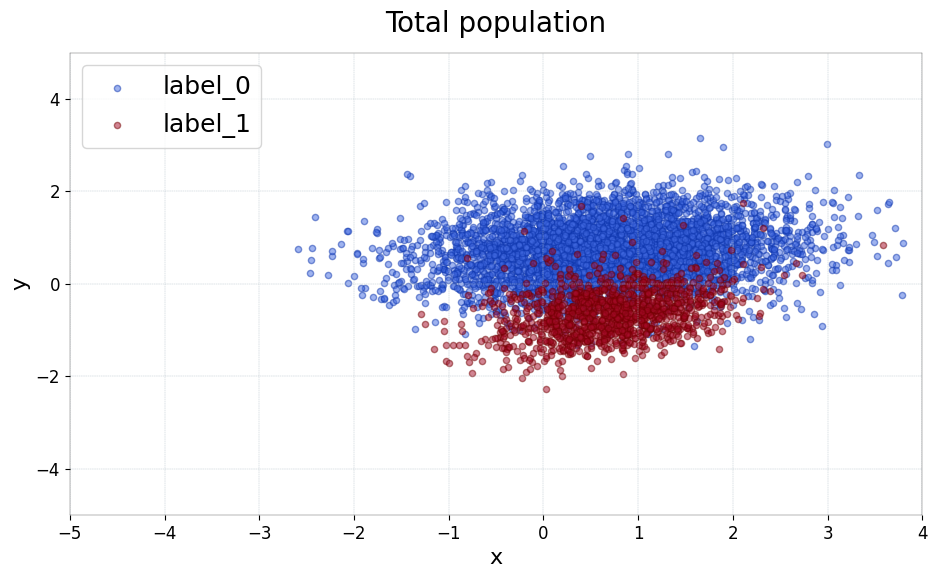

In [ ]:
create_plot(df, title='Total population', figsize=(11,6))

In [ ]:
np.random.seed(1)
df2 = df[df['clusters']==2].copy()
df2['x'] = df2['x']-3
df2['y'] = df2['y'] + np.random.randn(df2.shape[0])
df2['clusters'] = 3
df2.head()

,x,y,label,clusters
4800,-1.665401,1.123698,1,3
4801,-3.108859,-1.761263,1,3
4802,-2.158495,-1.641539,1,3
4803,-2.707163,-2.070732,1,3
4804,-2.625760,0.269337,1,3


In [ ]:
df = pd.concat((df, df2))

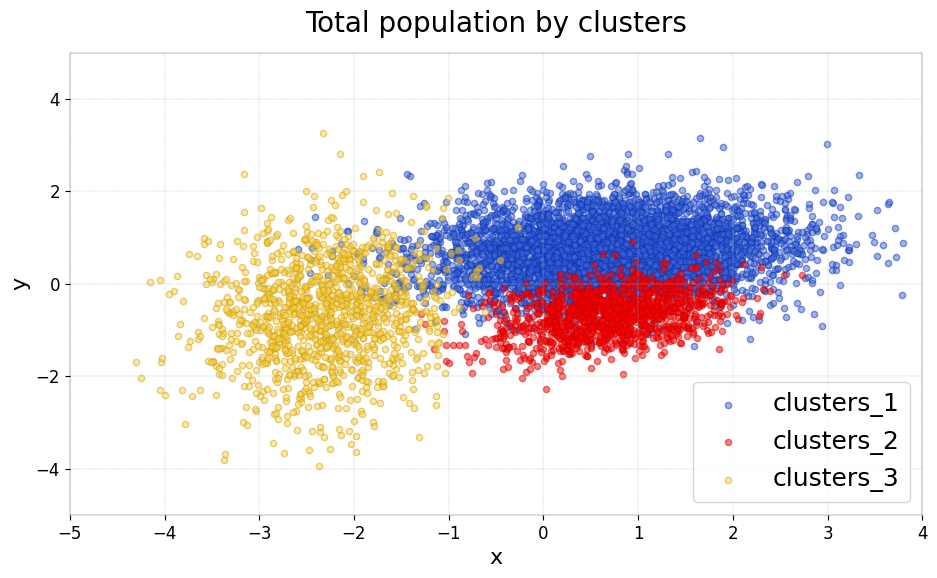

In [ ]:
create_plot(df, title='Total population by clusters', group_by='clusters',
            colors={1: '#4169e1', 2: '#FF0000', 3: '#ffd343', 4: '#0000FF'},
            ylim=[-5, 5], figsize=(11,6))

In [ ]:
#"Hiding" cluster 3
iCl2 = np.where(df['clusters'] == 3)
iCl134 = np.where(df['clusters'] != 3)

In [ ]:
np.random.seed(1)
rsize = round(Counter(y[iCl134])[1]*0.5)
bsize = rsize
iRedTrain = np.random.choice(np.where(y[iCl134]==1)[0], size=rsize, replace=False)
iBlueTrain = np.random.choice(np.where(y[iCl134]==0)[0], size=bsize, replace=False)

X = df[['x', 'y']].to_numpy()
y = df['label'].to_numpy()
y_cluster = df['clusters'].to_numpy()

X_bal = X[iCl134][np.concatenate((iBlueTrain, iRedTrain))]
y_bal = y[iCl134][np.concatenate((iBlueTrain, iRedTrain))]
X_test = np.concatenate((X[iCl2], X[iCl134][[i for i in range(X[iCl134].shape[0]) if i not in np.concatenate((iBlueTrain, iRedTrain))]]))
y_test = np.concatenate((y[iCl2], y[iCl134][[i for i in range(X[iCl134].shape[0]) if i not in np.concatenate((iBlueTrain, iRedTrain))]]))

In [ ]:
# Stratified selection for training and val
X_train_bal, X_val_bal, y_train_bal, y_val_bal = train_test_split(X_bal,
                                                                  y_bal,
                                                                  stratify=y_bal,
                                                                  random_state=1,
                                                                  test_size=0.3)

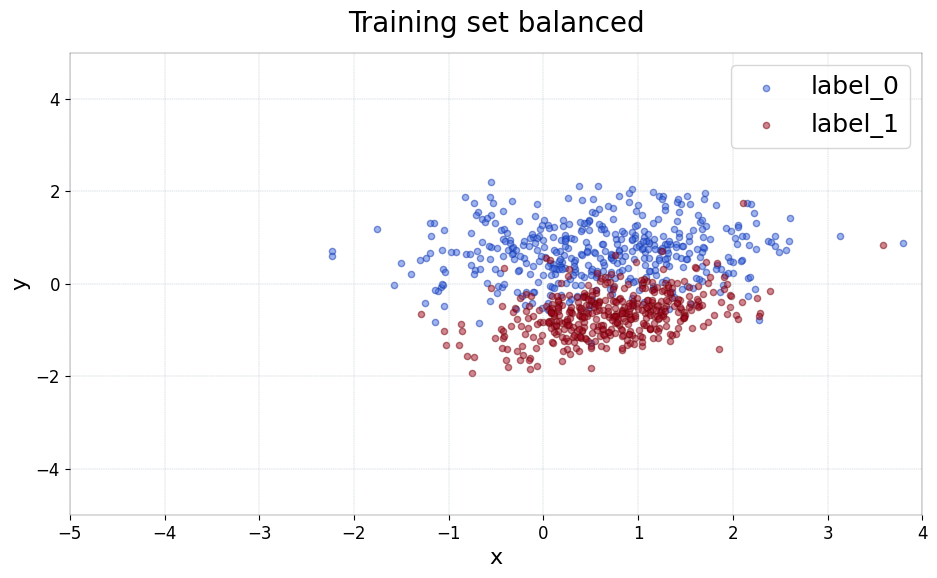

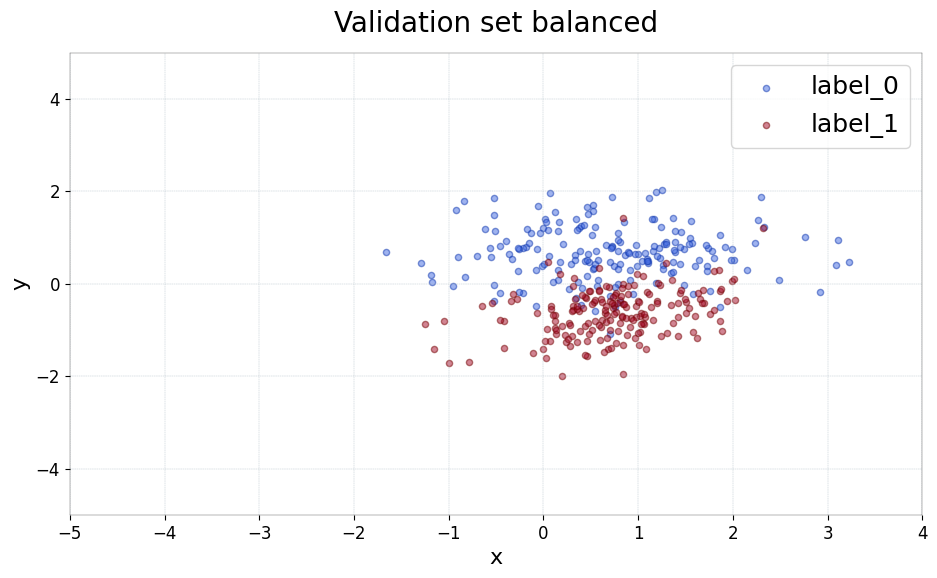

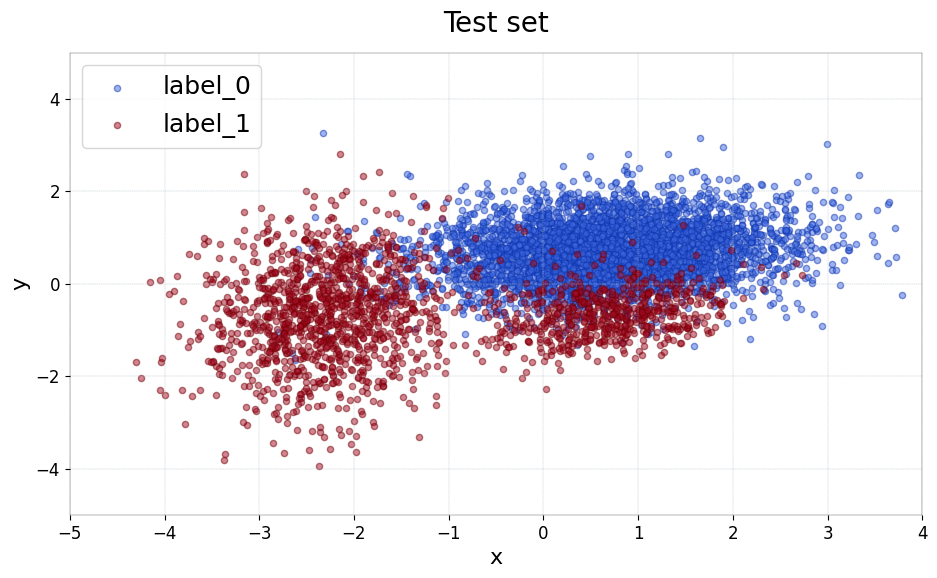

In [ ]:
create_plot(pd.DataFrame(dict(x=X_train_bal[:, 0],
                              y=X_train_bal[:, 1], label=y_train_bal)),
            title='Training set balanced', figsize=(11,6))
create_plot(pd.DataFrame(dict(x=X_val_bal[:, 0],
                              y=X_val_bal[:, 1], label=y_val_bal)),
            title='Validation set balanced', figsize=(11,6))
create_plot(pd.DataFrame(dict(x=X_test[:, 0],
                              y=X_test[:, 1], label=y_test)),
            title='Test set', figsize=(11,6))

In [ ]:
c_training = Counter(y_train_bal)
c_test = Counter(y_test)
c_val = Counter(y_val_bal)

print('*****Training set*****\nNumber of examples in class 0:', c_training[0],
      '\nNumber of examples in class 1', c_training[1])
print('*****Validation set*****\nNumber of examples in class 0:', c_val[0],
      '\nNumber of examples in class 1', c_val[1])
print('*****Test set*****\nNumber of examples in class 0:', c_test[0],
      '\nNumber of examples in class 1', c_test[1])

*****Training set*****
Number of examples in class 0: 428 
Number of examples in class 1 428
*****Validation set*****
Number of examples in class 0: 184 
Number of examples in class 1 184
*****Test set*****
Number of examples in class 0: 4168 
Number of examples in class 1 1808


TRAINING OF THE CLASSIFIER

In [ ]:
# Training
clf = RandomForestClassifier(random_state=1, min_samples_leaf=10,
                             n_estimators=100)

clf.fit(X_train_bal, y_train_bal)

# Prediction on the test set
ypred_test = clf.predict(X_test)
ypred_proba_test = clf.predict_proba(X_test)

# Prediction on the validation set
ypred_val = clf.predict(X_val_bal)
ypred_proba_val = clf.predict_proba(X_val_bal)

# Prediction on the training set
ypred_train = clf.predict(X_train_bal)
ypred_proba_train = clf.predict_proba(X_train_bal)

RELIABILITY ASSESSMENT

In [ ]:
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple ReliabilityPackage --upgrade

Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple


In [ ]:
from ReliabilityPackage.ReliabilityFunctions import *

Build an Autoencoder on the training set

In [ ]:
ae = create_and_train_autoencoder(X_train_bal, X_val_bal, batchsize=80, layer_sizes = [2, 4, 20], epochs=1000, optimizer_params = {'lr': 0.01, 'weight_decay': 1e-8})

Generate the Dataset of the synthetic points and compute their associated accuracies

In [ ]:
syn_pts, acc_syn_pts = generate_synthetic_points(problem_type='classification', predict_func=clf.predict, , X_train=X_train_bal, y_train=y_train_bal, method='GN', k=5)

Define a MSE threshold and an Accuracy threshold

In [ ]:
mse_thresh = perc_mse_threshold(ae, X_val_bal, perc=98)
acc_thresh = 0.85

Generate an instance of the Reliability Detector Class (class-object able to evaluate the pointwise reliability of instances)

In [ ]:
RD = create_reliability_detector('classification', ae, syn_pts, acc_syn_pts, mse_thresh=mse_thresh, perf_thresh=acc_thresh, proxy_model="MLP")

Evaluate the reliability of the Training, Validation, and Test sets

In [ ]:
train_reliability= compute_dataset_reliability(RD, X_train_bal, mode='total')
reliable_train = X_train_bal[np.where(train_reliability == 1)]
y_reliable_train =y_train_bal[np.where(train_reliability == 1)]
ypred_reliable_train = clf.predict(reliable_train)
unreliable_train = X_train_bal[np.where(train_reliability == 0)]
y_unreliable_train =y_train_bal[np.where(train_reliability == 0)]
ypred_unreliable_train = clf.predict(unreliable_train)

val_reliability= compute_dataset_reliability(RD, X_val_bal, mode='total')
reliable_val = X_val_bal[np.where(val_reliability == 1)]
y_reliable_val = y_val_bal[np.where(val_reliability == 1)]
ypred_reliable_val = clf.predict(reliable_val)
unreliable_val = X_val_bal[np.where(val_reliability == 0)]
y_unreliable_val = y_val_bal[np.where(val_reliability == 0)]
ypred_unreliable_val = clf.predict(unreliable_val)

test_reliability= compute_dataset_reliability(RD, X_test, mode='total')
reliable_test = X_test[np.where(test_reliability == 1)]
y_reliable_test = y_test[np.where(test_reliability == 1)]
ypred_reliable_test = clf.predict(reliable_test)
unreliable_test = X_test[np.where(test_reliability == 0)]
y_unreliable_test = y_test[np.where(test_reliability == 0)]
ypred_unreliable_test = clf.predict(unreliable_test)

In [138]:
print("Training set:")
print("Reliable:", reliable_train.shape[0], "(",reliable_train.shape[0]/train_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_train.shape[0], "(",unreliable_train.shape[0]/train_reliability.shape[0]*100,"%)")
print("\nValidation set:")
print("Reliable:", reliable_val.shape[0], "(",reliable_val.shape[0]/val_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_val.shape[0], "(",unreliable_val.shape[0]/val_reliability.shape[0]*100,"%)")
print("\nTest set:")
print("Reliable:", reliable_test.shape[0], "(",reliable_test.shape[0]/test_reliability.shape[0]*100,"%)")
print("Unreliable:", unreliable_test.shape[0], "(",unreliable_test.shape[0]/test_reliability.shape[0]*100,"%)")

Training set:
Reliable: 602 ( 70.32710280373831 %)
Unreliable: 254 ( 29.672897196261683 %)

Validation set:
Reliable: 251 ( 68.20652173913044 %)
Unreliable: 117 ( 31.793478260869566 %)

Test set:
Reliable: 3566 ( 59.67202141900937 %)
Unreliable: 2410 ( 40.32797858099063 %)


In [139]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score, matthews_corrcoef, average_precision_score, brier_score_loss

def compute_metrics(y, ypred):
  scores = []
  scores.append(accuracy_score(y, ypred))
  scores.append(precision_score(y, ypred))
  scores.append(recall_score(y, ypred))
  scores.append(roc_auc_score(y, ypred))
  scores.append(f1_score(y, ypred))
  scores.append(matthews_corrcoef(y, ypred))
  scores.append(average_precision_score(y, ypred))
  scores.append(brier_score_loss(y, ypred))

  return scores

In [140]:
#Function to plot the metrics' plots
def metrics_plots(y, ypred, rel_y, rel_ypred, unrel_y, unrel_ypred, name):
  fig, ax = plt.subplots(figsize=(19, 7))
  xbarplot = np.arange(8)
  y1barplot = compute_metrics(y, ypred)
  y2barplot = compute_metrics(rel_y, rel_ypred)
  y3barplot = compute_metrics(unrel_y, unrel_ypred)

  bar_width = 0.27

  b1 = ax.bar(xbarplot, y1barplot, width = bar_width, color='steelblue')
  b2 = ax.bar(xbarplot+bar_width, y2barplot, width = bar_width, color='lightgreen')
  b3 = ax.bar(xbarplot+2*(bar_width), y3barplot, width = bar_width, color='salmon')

  ax.set_xticks(xbarplot + 2*(bar_width) / 2)
  ax.set_xticklabels(['Accuracy', 'Precision','Recall', 'AUC', 'f1-score', 'MCC', 'PRC', 'Brier Score'], fontsize=14)
  ax.legend([name,"Reliable "+name, "Unreliable "+name], fontsize=11)

  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['bottom'].set_color('#DDDDDD')
  ax.tick_params(bottom=False, left=False)
  ax.set_axisbelow(True)
  ax.yaxis.grid(True, color='#EEEEEE')
  ax.xaxis.grid(False)

  # Add axis and chart labels.
  ax.set_title('Performance '+name, pad=15, fontsize=18)

  for bar in ax.patches:
    # The text annotation for each bar should be its height.
    bar_value = round(bar.get_height(),3)
    # Format the text with commas to separate thousands. You can do
    # any type of formatting here though.
    text = f'{bar_value:,}'
    # This will give the middle of each bar on the x-axis.
    text_x = bar.get_x() + bar.get_width() / 2
    # get_y() is where the bar starts so we add the height to it.
    text_y = bar.get_y() + bar_value
    # If we want the text to be the same color as the bar, we can
    # get the color like so:
    bar_color = 'black'
    # If you want a consistent color, you can just set it as a constant, e.g. #222222
    ax.text(text_x, text_y, text, ha='center', va='bottom', color=bar_color,
            size=12)

  # Set the fontsize for y-axis bar values
  ax.yaxis.set_tick_params(labelsize=10)
  #fig.tight_layout()

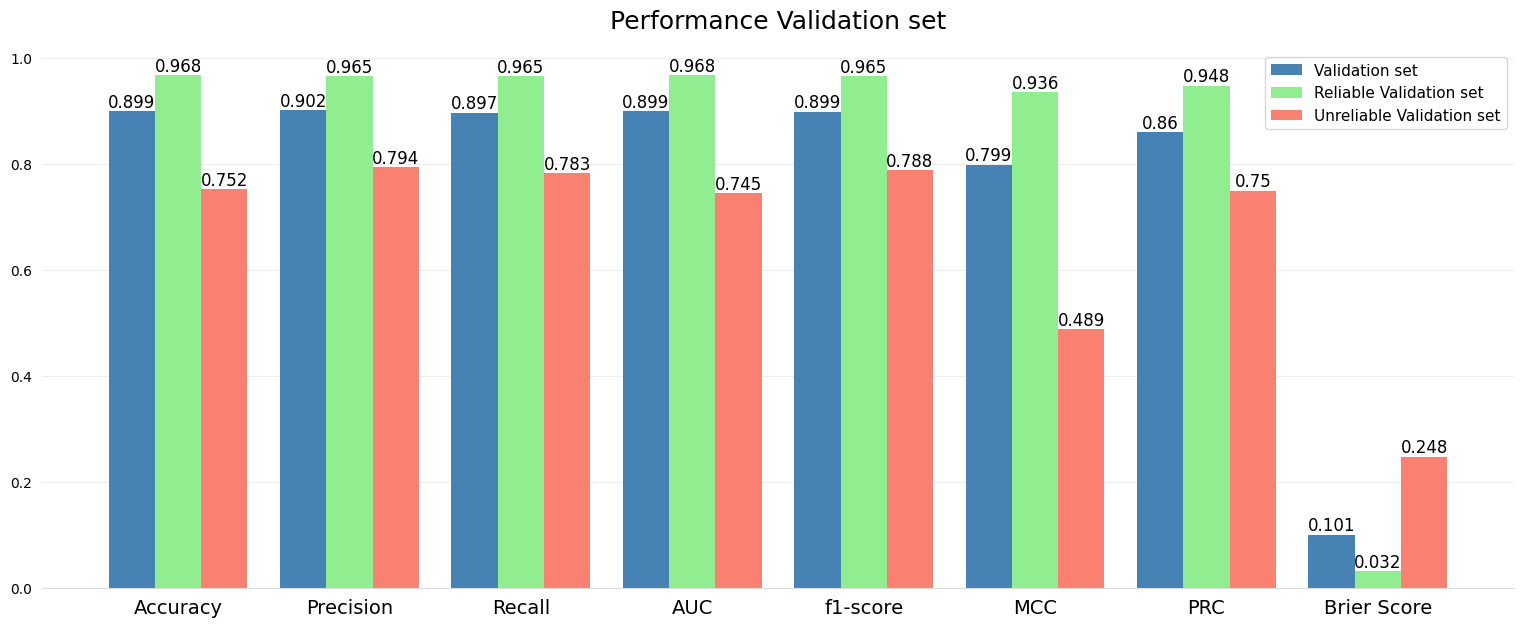

In [141]:
metrics_plots(y_val_bal, ypred_val, y_reliable_val, ypred_reliable_val, y_unreliable_val, ypred_unreliable_val,'Validation set')

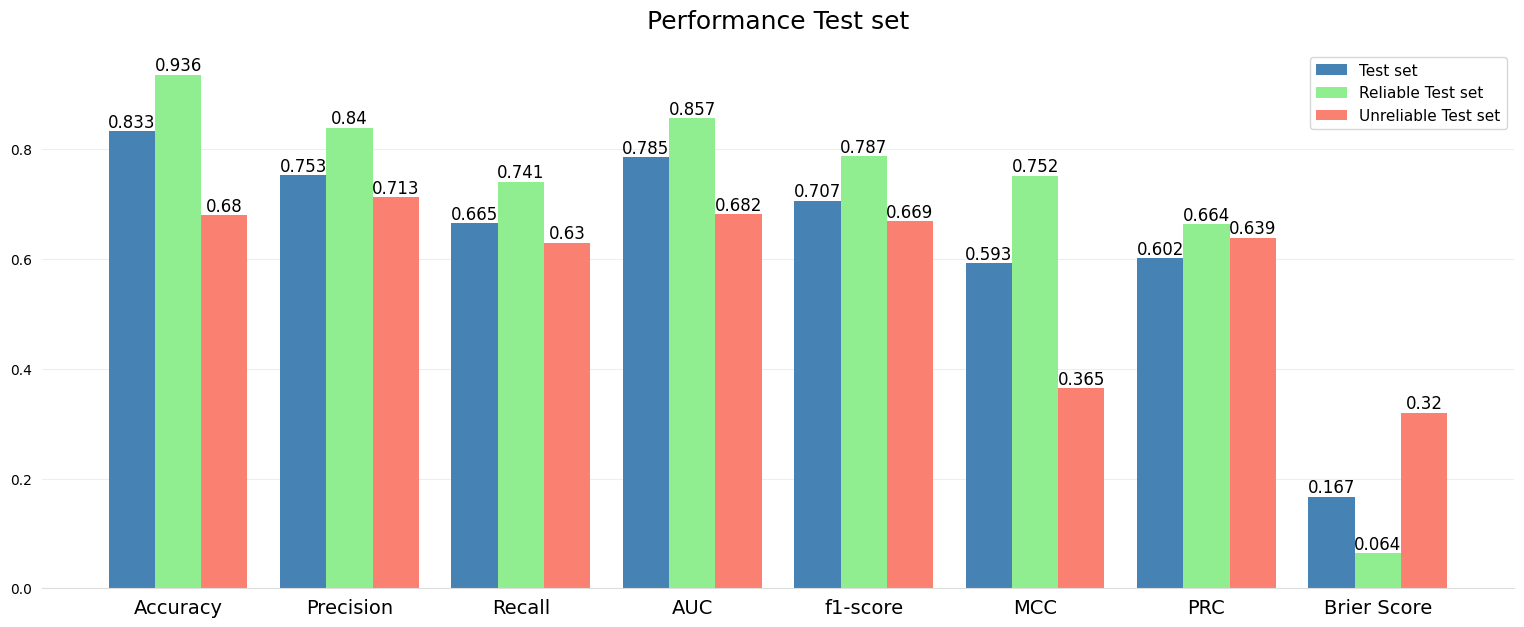

In [142]:
metrics_plots(y_test, ypred_test, y_reliable_test, ypred_reliable_test, y_unreliable_test, ypred_unreliable_test,'Test set')

DataFrame containing the labelled reliable/unreliable instances of the Test set

In [ ]:
p_df_test_rel = pd.DataFrame(dict(x=reliable_test[:,0], y=reliable_test[:,1],reliable=np.ones(len(reliable_test))))
p_df_test_unrel = pd.DataFrame(dict(x=unreliable_test[:,0], y=unreliable_test[:,1],reliable=np.zeros(len(unreliable_test))))
p_df_test = pd.concat([p_df_test_rel,p_df_test_unrel])

Test set Reliability

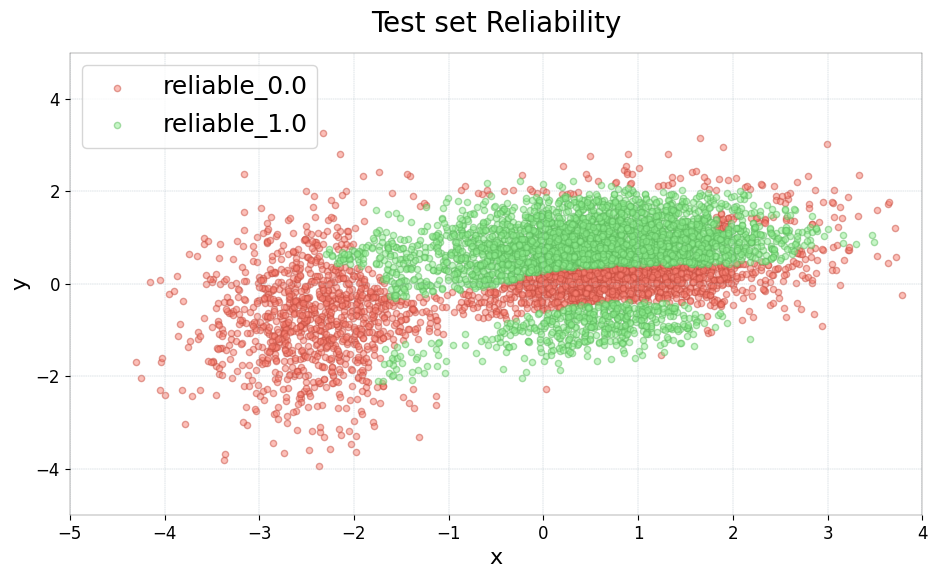

In [ ]:
create_plot(p_df_test, colors = {0:'#fa8072', 1:'#90EE90'}, title='Test set Reliability',
            group_by='reliable', figsize=(11,6))